# In previous simulations a dip in the bound density in the membrane absorption region was observed: let's investigate
In `2018-10-8-rk-persistence-length` a discontinuity is observed in the bound PAK density at a small persistence length. The simulations with a small persistence length have fast MT binding and unbinding, so it is likely that this somehow effects the PAK density.

The data of the simulations can be found in: `/data/simulations/2018-11-1-cB-density-drop-edge/`

## Setup of the investigation
Because the dip in the PAK density overlaps with the region where membrane absorption takes place, the investigation started with changing the parameters concerning membrane absorption. 
1. First: the timestep was lowered to check if this fluctuation in the density is due to the timestep
1. Second: the membrane absorption was removed 
1. Third: the membrane absorption rate was gradually varied
1. Fourth: the membrane absorption distance was gradually varied

With these set of simulations I will investigate how the absorption process influences the bound PAK density. 

In [20]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [21]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#import matplotlib.cm as cm # some colormaps
import seaborn as sb
import numpy as np
import pandas as pd

import os 
import sys
import re
sys.path.append("../source")

import matplotlib.colors 

In [22]:
# lets check if we can make the plotting interactive
import ipywidgets 
#ipywidgets works, but to make it work in the .html file I need nbinteract
#https://www.youtube.com/watch?v=jln6h-dE2-0


# another try is to use this instead of inline
#%matplotlib notebook # switching from inline -> notebook without restart doesnt work

In [24]:
# custom settings
sb.set()
plt.rcParams['figure.figsize'] =  (12,8)

%config InlineBackend.figure_format='retina'

# prefix that helps to determine from which notebook a figure came from
fig_prefix = "/home/ipausers/kools/Documents/MasterProject/Jupyter_Notebooks/figures/2018-11-05-rk"

In [25]:
## function that can take the data from the 
def get_xy_from_csv_file(csv_file_path):
    '''
    get x, y value from csv file
    csv file format: xmin, xmax, y
    '''
    x = []
    y = []

    for line in open(csv_file_path):
        #only read lines that are not empty 
        if line.strip():
            list = line.split(" ")

            temp_xmin = float(list[0])
            temp_xmax = float(list[1])
            temp_y = float(list[2])
            
            # I estimate that x = middle of box
            #temp_x = (temp_xmin+temp_xmax)/2.0
            
            x.append((temp_xmax+temp_xmin)/2)
            y.append(temp_y)
            #x.append(temp_xmax)
            #y.append(temp_y)
            
    return x, y

# I want this one because with the MT length distribution the maximum length is 9 
# now it looks like the maximum length can be higher than 9
def get_xy_from_csv_file_modified(csv_file_path):
    '''
    get x, y value from csv file
    csv file format: xmin, xmax, y
    '''
    x = []
    y = []

    for line in open(csv_file_path):
        #only read lines that are not empty 
        if line.strip():
            list = line.split(" ")

            temp_xmin = float(list[0])
            temp_xmax = float(list[1])
            temp_y = float(list[2])
            
            # I estimate that x = middle of box
            #temp_x = (temp_xmin+temp_xmax)/2.0
            
            x.append((temp_xmin+temp_xmin)/2)
            y.append(temp_y)
            #x.append(temp_xmax)
            #y.append(temp_y)
            
    return x, y

# function that creates a range of floats 
def frange(start, end=None, inc=None):
    "A range function, that does accept float increments..."

    if end == None:
        end = start + 0.0
        start = 0.0

    if inc == None:
        inc = 1.0

    L = []
    while 1:
        next = start + len(L) * inc
        if inc > 0 and next >= end:
            break
        elif inc < 0 and next <= end:
            break
        L.append(next)
        
    return L

In [26]:
# grabs the first number from a text file on a line where "afterstring" is found
# usage: enter a unique string for "afterstring" and it gets the number after that string

# right now it only gets 1 number (I think), the afterstring needs to be the exact string upto the number
# and it can not handle numbers with a comma or exponent 
def get_number_from_output(outputPath, afterstring):    
    for line in open(outputPath):
        match = re.search(afterstring+'([-+]?\d*\.\d+|\d+)', line) 
        if match:
            return float(match.group(1))

# SET 1 varying timestep
Lets check if the problem is timestep related.

## Settings
Simulation folder: `/data/simulations/2018-11-1-cB-density-drop-edge/timeStep`. Settings used in this simulation: 

| Variable |     Value       |  
|:----------:|:-------------:|
| Steps      |  $1$b         |
| time-step  |    $[0.001, 0.0005, 0.0001, 0.00005, 0.00001] s$   |
| Number of PAK | $200$|
| radius of the space | $ 10 \mu m$ | 
| PAK diffusion constant| $1 \mu m^2/s$|
| membrane absorption distance | $0.5 \mu m$ | 
| membrane absorption rate | $40/s$ |
| membrane desorption rate | $20/s$ | 
| MT binding distance | $0.1 \mu m$ |
| MT binding rate | $100/s$ | 
| MT unbinding rate | $10/s$ |
| MT transport speed | $0.1 \mu m/s$| 
| Number of MT$^*$ | $100$ | 
 
- \* : A constant MT density of 100 MT that are distributed evenly among all angles is used.

- The aster (MT organizing center) is precisely in the center of the spherical simulations space. The aster has a solid core with a radius of $ 1 \mu m$. All MT have to grow $9\mu m$ to reach the boundary. 

In [44]:
'''
Get free PAK densities
'''
# walk through the folders and save the necessary data to a list: [(pLength,x1,y1),...,(pLength,xn,yn)]

# range of timesteps that will be gathered : 
timeSteps = [0.001, 0.0005, 0.0001, 0.00005, 0.00001]

simDirHead = "/data/simulations/2018-11-1-cB-density-drop-edge/timeStep/"
simName = "tStep_" 
outputFileName = "PAK_radius_density.csv"

data1_free = []

# look in all folders and collect the data
for dT in timeSteps: # the first persistance length was part of another simulation
    simDir = simDirHead + simName + str(dT)
    
    if os.path.exists(simDir):
        os.chdir(simDir)
        outputFilePath = simDir + "/" + outputFileName
        
        if os.path.isfile(outputFilePath):
            x,y = get_xy_from_csv_file(outputFilePath)
            data1_free.append((dT,np.array(x),np.array(y)))
        
        else:
            print("File with path", outputFilePath, "does not exist")
    
    else:
        print("Directory", simDir, "does not exist.")

In [45]:
'''
Get Bound PAK densities
'''
# walk through the folders and save the necessary data to a list: [(pLength,x1,y1),...,(pLength,xn,yn)]

# range of timesteps that will be gathered : 
timeSteps = [0.001, 0.0005, 0.0001, 0.00005, 0.00001]

simDirHead = "/data/simulations/2018-11-1-cB-density-drop-edge/timeStep/"
simName = "tStep_" 
outputFileName = "PAK_Bound_radius_density.csv"

# data1 because I call this set 1 in this notebook
data1_bound = []

# look in all folders and collect the data
for dT in timeSteps: # the first persistance length was part of another simulation
    simDir = simDirHead + simName + str(dT)
    
    if os.path.exists(simDir):
        os.chdir(simDir)
        outputFilePath = simDir + "/" + outputFileName
        
        if os.path.isfile(outputFilePath):
            x,y = get_xy_from_csv_file(outputFilePath)
            data1_bound.append((dT,np.array(x),np.array(y)))
        
        else:
            print("File with path", outputFilePath, "does not exist")
    
    else:
        print("Directory", simDir, "does not exist.")

    
        

In [46]:
'''
It is also necessary to normalize the data in some way

I decided to normalize each free PAK density to 1. (so the each histogram value is divided by the average histogram value)
The bound PAK density of the same simulation also needs to be normalized with the same normalization constant

- So if there are 2 times more bound PAK then the average hist value for bound PAK will be 2 
'''
# FREE PAK
#normalization constants
normConst1 = [] # 1 because it is set 1 
for line in data1_free: 
    averageHistValue = 0
    
    density = line[2]
    
    # I choose to ignore the first and last data points
    for value in density[1:-1]:
        averageHistValue += value
    
    averageHistValue /= len(density[1:-1])
    
    normConst1.append(averageHistValue)

# normalize free PAK density
data1_free_normalized = []
count = 0
for line in data1_free:
    dT = line[0]
    radius = np.array(line[1])
    density = np.array(line[2])
    
    normDensity = np.true_divide(density, normConst1[count])

    # make sure the list has the same structure as before (I did change the lists to numpy arrays, though)
    data1_free_normalized.append((dT, radius, normDensity))
    
    count += 1 
    
# normalize bound PAK density
data1_bound_normalized = []
count = 0
for line in data1_bound:
    dT = line[0]
    radius = np.array(line[1])
    density = np.array(line[2])
    
    normDensity = np.true_divide(density, normConst1[count])
    
    # make sure again that the data has the same format
    data1_bound_normalized.append((dT, radius, normDensity))
    
    count += 1

## Set1: Plot data at variying timesteps

In [47]:
'''
Plot the data using matplotlib
'''
def plotFreePAK(LogLog, data1_free_normalized):
    ax = plt.subplot(111)

    #colors
    NUM_COLORS = len(data1_free_normalized)
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    ax.set_prop_cycle('color', colors)

    for data in data1_free_normalized:
        dT = data[0]
        radius = data[1][1:-1] # ignore the first data point since it is inside the solid core of the aster
        density = data[2][1:-1]

        ax.plot(radius, density, label="$\Delta t=$"+str(dT), ls="-", marker=".", ms=5) 

    # some style settings
    plt.title("Free PAK density: constant $m_B$ varying timestep")
    plt.xlabel("$r$")
    plt.ylabel("$c_f\,(r)$")
    if(LogLog):
        ax.set_yscale('log')
        ax.set_xscale('log')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
                  fancybox=True, shadow=True, ncol=5)

    # change the xticks
    loc = ticker.MultipleLocator(base=1.0)
    ax.xaxis.set_major_locator(loc)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    #plt.tight_layout()
    #plt.savefig(fig_prefix + "tSpeed-constant-m.png", bbox_inches='tight')

# video: https://www.youtube.com/watch?v=rkBPgTL-D3Y
ipywidgets.interact(plotFreePAK, data1_free_normalized=ipywidgets.fixed(data1_free_normalized), LogLog=True)

#plotFreePAK(True, data1_free_normalized)

interactive(children=(Checkbox(value=True, description='LogLog'), Output()), _dom_classes=('widget-interact',)…

<function __main__.plotFreePAK(LogLog, data1_free_normalized)>

<function matplotlib.pyplot.show(*args, **kw)>

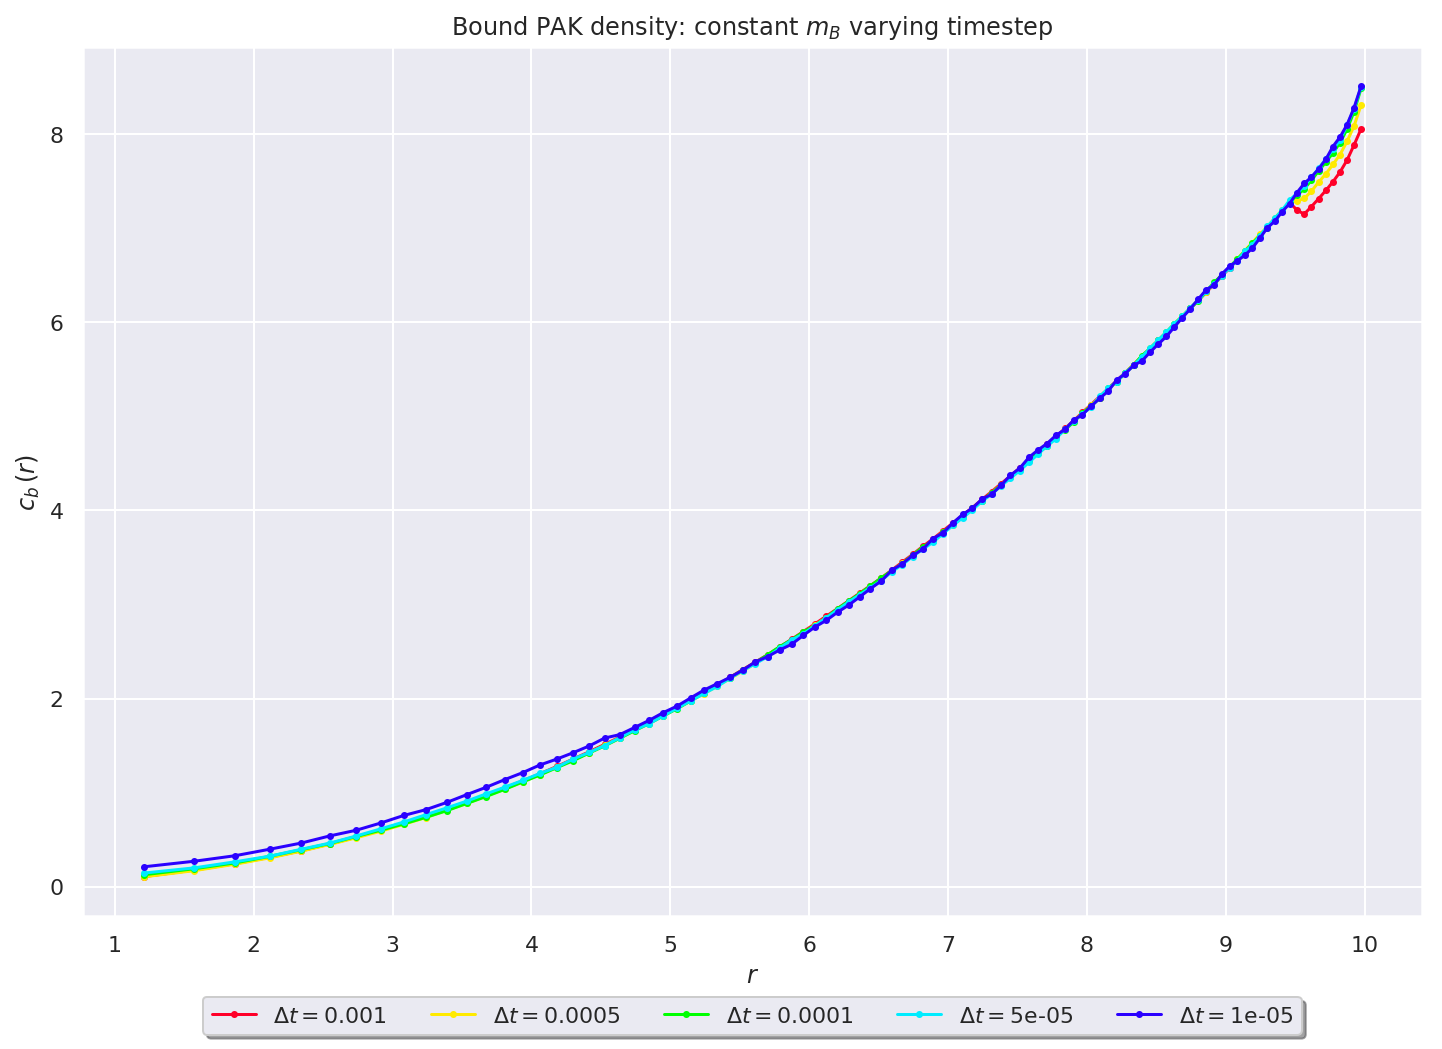

In [48]:
'''
Plot the data using matplotlib
'''

ax = plt.subplot(111)

#colors
NUM_COLORS = len(data1_bound_normalized)
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
ax.set_prop_cycle('color', colors)

for data in data1_bound_normalized:
    dT = data[0]
    radius = data[1][1:] # ignore first data point since it is inside the solid core of the aster
    density = data[2][1:]
    
    ax.plot(radius, density, label="$\Delta t=$"+str(dT), ls="-", marker=".", ms=5) 

# some style settings
plt.title("Bound PAK density: constant $m_B$ varying timestep")
plt.xlabel("$r$")
plt.ylabel("$c_b\,(r)$")
#ax.set_yscale('log')
#ax.set_xscale('log')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
              fancybox=True, shadow=True, ncol=5)

# change the xticks
loc = ticker.MultipleLocator(base=1.0)
ax.xaxis.set_major_locator(loc)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

#plt.tight_layout()
#plt.savefig(fig_prefix + "tSpeed-constant-m.png", bbox_inches='tight')
plt.show

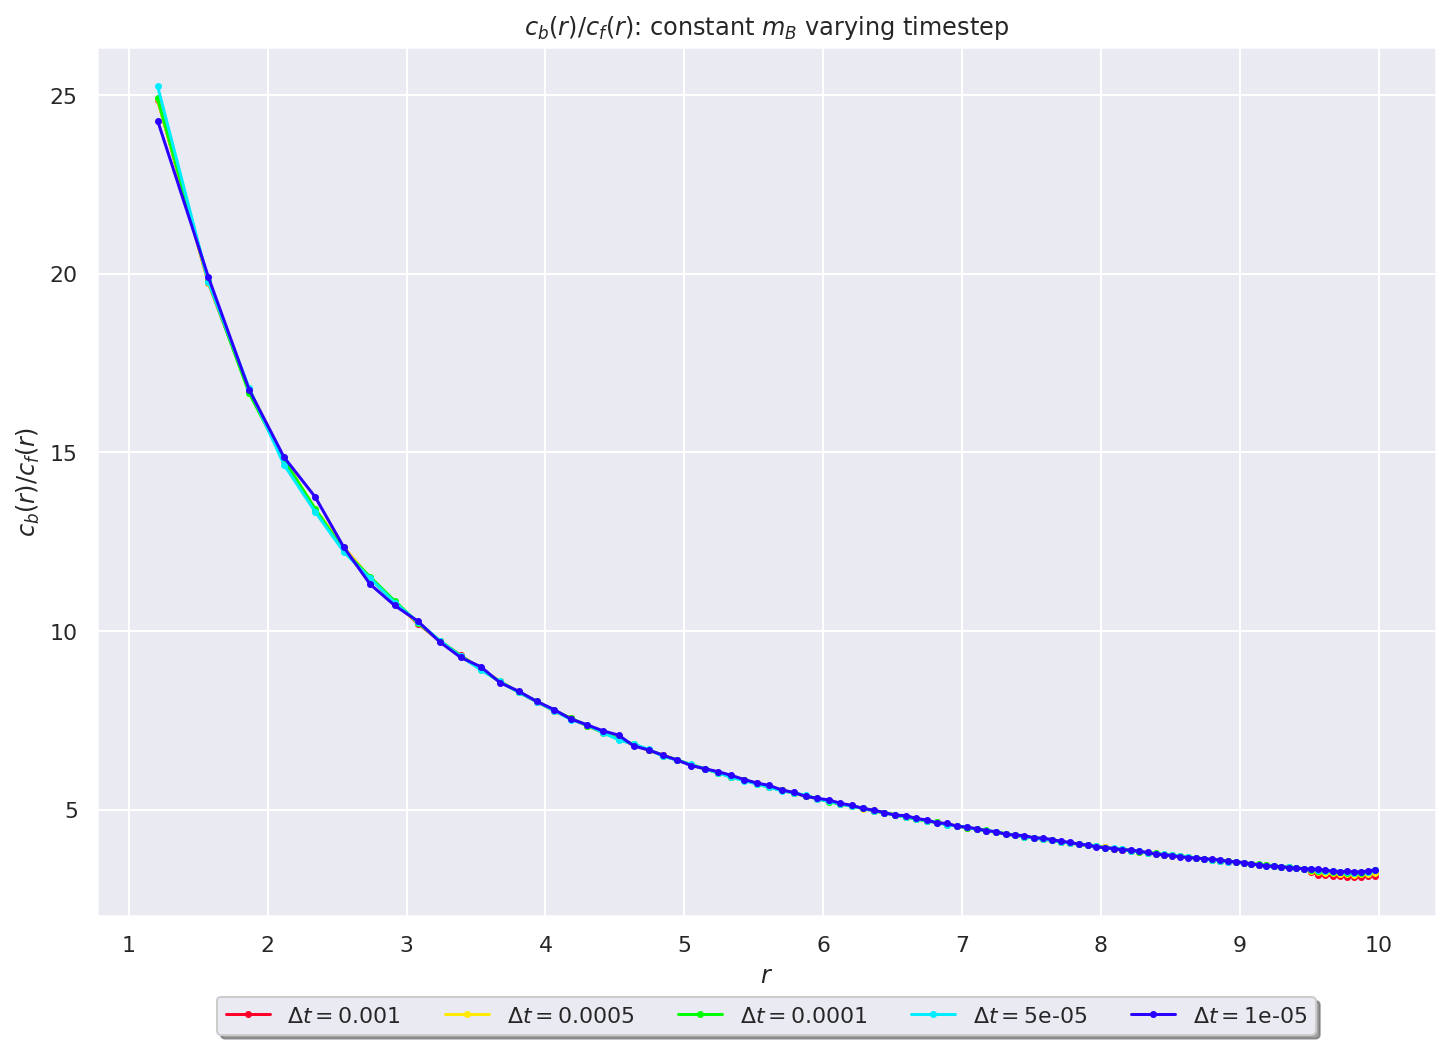

In [49]:
'''
Plot the data using matplotlib
'''

ax = plt.subplot(111)

#colors
NUM_COLORS = len(data1_bound_normalized)
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
ax.set_prop_cycle('color', colors)

count = 0
for data in data1_free_normalized:
    dT = data[0]
    radius = data[1][1:] # ignore first data point since it is inside the solid core of the aster
    
    densityFree = data[2][1:]
    densityBound = data1_bound_normalized[count][2][1:]
    
    fractionBoundFree = densityBound/densityFree
    
    ax.plot(radius, fractionBoundFree, label="$\Delta t=$"+str(dT), ls="-", marker=".", ms=5) 
    
    count += 1

# some style settings
plt.title("$c_b(r)/c_f(r)$: constant $m_B$ varying timestep")
plt.xlabel("$r$")
plt.ylabel("$c_b(r)/c_f(r)$")
#ax.set_yscale('log')
#ax.set_xscale('log')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
              fancybox=True, shadow=True, ncol=5)

# change the xticks
loc = ticker.MultipleLocator(base=1.0)
ax.xaxis.set_major_locator(loc)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

#plt.tight_layout()
#plt.savefig(fig_prefix + "tSpeed-constant-m.png", bbox_inches='tight')


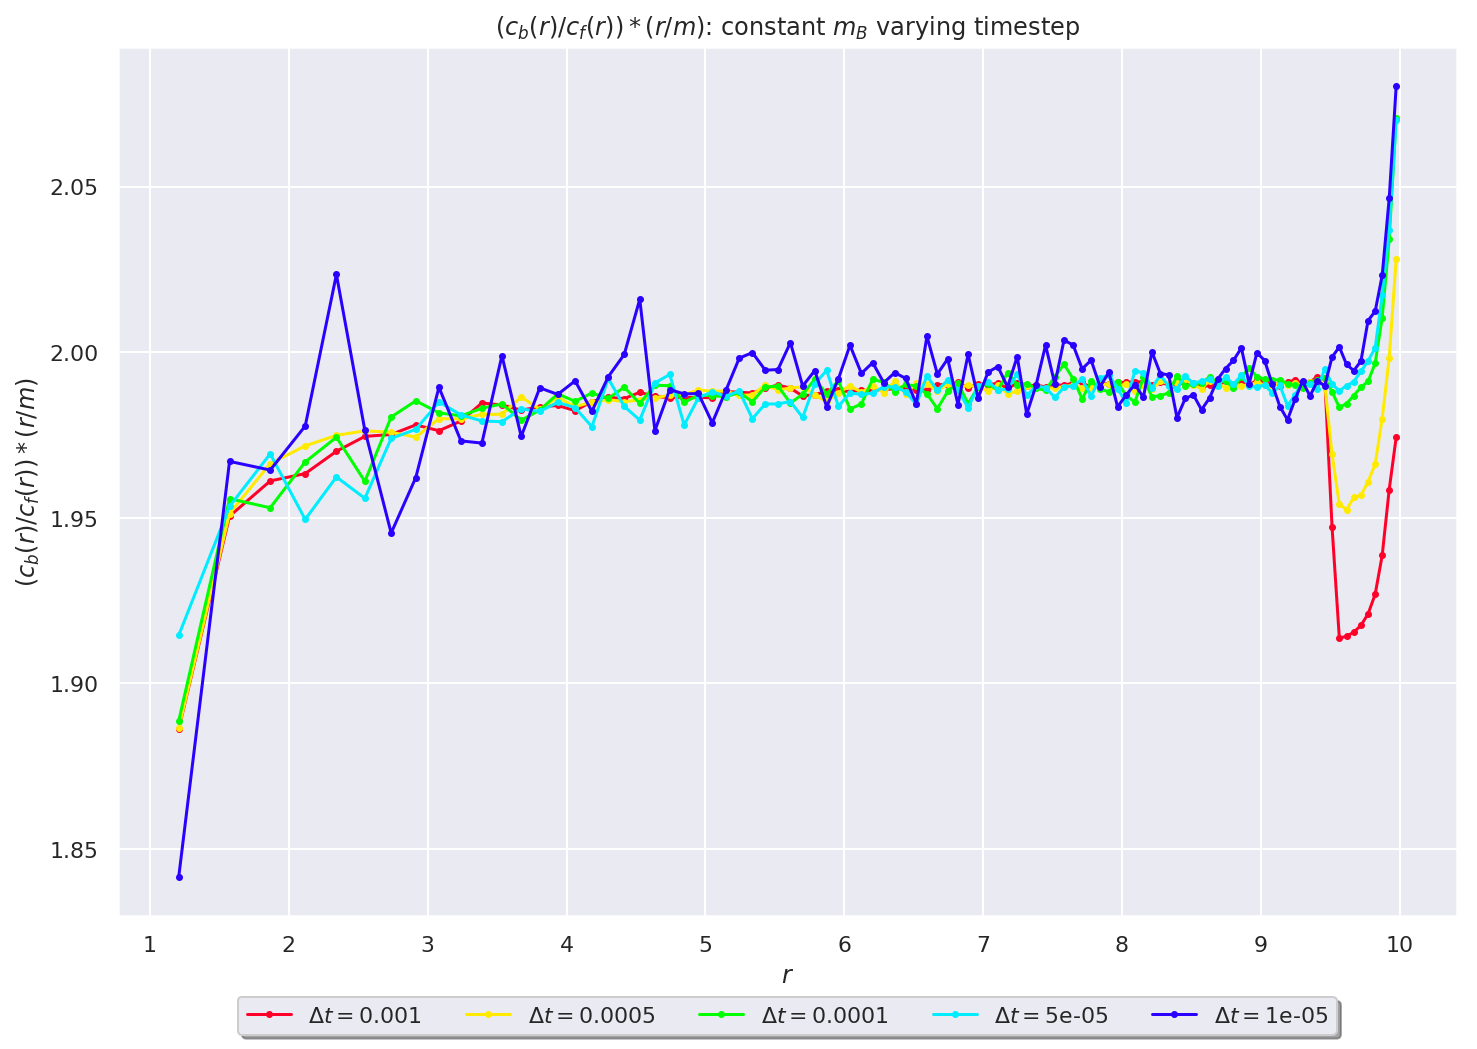

In [50]:
'''
Plot the data using matplotlib
'''

ax = plt.subplot(111)

#colors
NUM_COLORS = len(data1_bound_normalized)
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
ax.set_prop_cycle('color', colors)

count = 0
for data in data1_free_normalized:
    dT = data[0]
    radius = data[1][1:] # ignore first data point since it is inside the solid core of the aster
    
    densityFree = data[2][1:]
    densityBound = data1_bound_normalized[count][2][1:]
    
    fractionBoundFree = densityBound/densityFree
    
    MTatBoundary = 100 # this is constant
    
    fractionBoundFreeTimesRM = (fractionBoundFree * radius) / (MTatBoundary/(2*math.pi))
    
    ax.plot(radius, fractionBoundFreeTimesRM, label="$\Delta t=$"+str(dT), ls="-", marker=".", ms=5) 
    
    count += 1


# some style settings
plt.title("$(c_b(r)/c_f(r))*(r/m)$: constant $m_B$ varying timestep")
plt.xlabel("$r$")
plt.ylabel("$(c_b(r)/c_f(r))*(r/m)$")
#ax.set_yscale('log')
#ax.set_xscale('log')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
              fancybox=True, shadow=True, ncol=5)

# change the xticks
loc = ticker.MultipleLocator(base=1.0)
ax.xaxis.set_major_locator(loc)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

#plt.tight_layout()
#plt.savefig(fig_prefix + "tSpeed-constant-m.png", bbox_inches='tight')


# Explanation/thoughts
The "dip" is not observed at lower timesteps. However, especially the $(c_b(r)/c_f(r))*(r/m)$ shows that the sharp increase after the "dip" towards the boundary is still present. 

This could indicate that the bound PAK density $c_b(r)$ is slightly too large near the boundary, or that the free PAK density is slightly too small near the boundary. 

So this will be investigated further! 


_Also, it is clear that a smaller timestep might require even more steps to reduce noise_